In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt

In [5]:
# get train data (use for train & test )
path = lambda number:r"C:\Users\14020\Desktop\NCBDC 2019\Data\NormaliezdData\NormlizedTrainData"+'\\'+str(number)+".csv"
traindflist=[]
DFSIZE=158
for i in range(DFSIZE):
    df=pd.read_csv( path(i) ).iloc[:,1:]
    traindflist.append(df)

In [6]:
# get test data
path = lambda number:r"C:\Users\14020\Desktop\NCBDC 2019\Data\NormaliezdData\NormilizedTestData"+'\\'+str(number)+".csv"
testdflist=[]
DFSIZE=52
for i in range(DFSIZE):
    df=pd.read_csv( path(i) ).iloc[:,1:]
    testdflist.append(df)

# get data prepared

In [56]:
inputfeature=['total_voltage', 'total_current', 'soc', 'temp_max', 'temp_min',
       'motor_voltage', 'motor_current', 'total_P', 'motor_P',
       'tempMAXMINdiff', 'SOCgap']
outputfeature=['milediff']
TimeStep=24

# 带TimeStep的LSTM

In [61]:
RNNX=[]
RNNY=[]
for df in traindflist:
    X=df.loc[:,inputfeature].to_numpy()
    y=df.loc[:,outputfeature].to_numpy()
    lens=len(df)
    for index in range(TimeStep,lens):
        RNNX.append(X[index-TimeStep:index])
        RNNY.append(y[index-TimeStep:index].cumsum())
RNNX=np.array(RNNX)
RNNY=np.array(RNNY)

## 数据分为测试集和训练集（可没有此步 ，因为我们有选择测试数据集）

In [36]:
from sklearn.model_selection import train_test_split #这里是引用了交叉验证
X_train,X_test, y_train, y_test = train_test_split(RNNX,RNNY,test_size = 0.1,random_state=100)

In [28]:
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)

(37280, 30, 11) (37280, 30, 1) (9321, 30, 11) (9321, 30, 1)


In [63]:
X_train=RNNX
y_train=RNNY

## RNN

In [64]:
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop
import matplotlib.pyplot as plt
import math
import tensorflow as tf

### lr_reduce 设置损失不减则降低学习率
### checkPoint设置保存模型

In [65]:
PathName=r"C:\Users\14020\Desktop\NCBDC 2019\model\RNN"
filepath=PathName+"\\2ndl_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

D:\ANACONDA\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


### 设置模型输入

In [66]:
BUFFER_SIZE=100
BATCH_SIZE=25
train_data_single = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

##  设置模型结构

In [67]:
input_shape=X_train.shape[-2:]

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=input_shape,return_sequences=True))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
#single_step_model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001) , metrics = ['mean_squared_error'])

In [69]:
import time
EPOCHS=30
EVALUATION_INTERVAL=500
time_start=time.time()
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50,callbacks = [checkpoint , lr_reduce])
time_end=time.time()

Train for 500 steps, validate for 50 steps
Epoch 1/30
499/500 [============================>.] - ETA: 0s - loss: 0.2218
Epoch 00001: val_loss improved from -inf to 0.34171, saving model to C:\Users\14020\Desktop\NCBDC 2019\model\RNN\2ndl_weights.hdf5
500/500 [==============================] - 26s 51ms/step - loss: 0.2219 - val_loss: 0.3417
Epoch 2/30
499/500 [============================>.] - ETA: 0s - loss: 0.2132
Epoch 00002: val_loss improved from 0.34171 to 0.46561, saving model to C:\Users\14020\Desktop\NCBDC 2019\model\RNN\2ndl_weights.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
500/500 [==============================] - 6s 11ms/step - loss: 0.2134 - val_loss: 0.4656
Epoch 3/30
496/500 [============================>.] - ETA: 0s - loss: 0.2259
Epoch 00003: val_loss did not improve from 0.46561
500/500 [==============================] - 6s 11ms/step - loss: 0.2246 - val_loss: 0.2131
Epoch 4/30
496/500 [============================>.] - ETA

Epoch 29/30
498/500 [============================>.] - ETA: 0s - loss: 0.2414
Epoch 00029: val_loss did not improve from 0.46561

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000001235416985e-29.
500/500 [==============================] - 5s 11ms/step - loss: 0.2408 - val_loss: 0.1962
Epoch 30/30
497/500 [============================>.] - ETA: 0s - loss: 0.1873
Epoch 00030: val_loss did not improve from 0.46561

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000001536343539e-30.
500/500 [==============================] - 5s 11ms/step - loss: 0.1871 - val_loss: 0.1962


In [70]:
print('totally cost',time_end-time_start)

totally cost 195.12947845458984


## 画出模型loss曲线 查看收敛效果

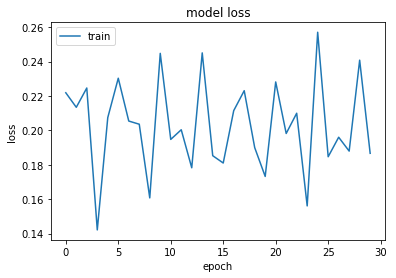

In [71]:
import matplotlib.pyplot as plt
plt.plot(single_step_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 对指定测试集的数据查看

In [88]:
number=0
df=testdflist[number]
TestX=[]
TestY=[]
X=df.loc[:,inputfeature].to_numpy()
y=df.loc[:,outputfeature].to_numpy()
lens=len(df)
for index in range(TimeStep,lens):
    if(int(index % TimeStep)==0):
        TestX.append(X[index-TimeStep:index])
        TestY.append(y[index-TimeStep:index].cumsum())
TestX=np.array(TestX)
TestY=np.array(TestY)
pred = single_step_model.predict(TestX)

In [89]:
result=[]
for i in pred:
    result.append(i[-1][0])

In [91]:
for index,y in enumerate(TestY):
    print("testY",index)
    for iindex,i in enumerate(y):
        print(iindex,i,pred[index][iindex])

testY 0
0 0.0 [0.04995978]
1 0.3000000000029104 [0.12250221]
2 0.19999999999708962 [0.24503885]
3 0.3666666666686069 [0.27791715]
4 0.5333333333328483 [0.27054843]
5 0.5999999999985448 [0.25913814]
6 0.6999999999970896 [0.21911395]
7 0.9499999999970896 [0.16793858]
8 1.0 [0.11936206]
9 1.1999999999970896 [0.11877968]
10 1.3999999999941792 [0.11825205]
11 1.3999999999941792 [0.18554483]
12 1.6999999999970896 [0.29337907]
13 1.5999999999985448 [0.22929935]
14 1.8000000000029104 [0.25216419]
15 2.0 [0.31726727]
16 2.0 [0.52098715]
17 2.1999999999970896 [0.5556901]
18 2.3999999999941792 [0.70333487]
19 2.5 [0.866886]
20 2.599999999998545 [1.0732005]
21 2.6999999999970896 [0.89559335]
22 2.7999999999956344 [1.1450988]
23 2.849999999991269 [1.2879698]
24 2.8999999999941792 [1.3704604]
25 2.8999999999941792 [1.4246963]
26 2.8999999999941792 [1.439525]
27 2.8999999999941792 [1.4495518]
28 2.8999999999941792 [1.3936507]
29 2.8999999999941792 [1.3322879]
testY 1
0 0.0 [-0.03210703]
1 0.0 [-0.073

4 0.5 [0.3991081]
5 0.7000000000043656 [0.50652176]
6 0.8000000000029104 [0.6344116]
7 0.9000000000014552 [0.96810883]
8 1.0 [1.0897877]
9 1.0 [1.2203507]
10 1.0 [1.1217196]
11 1.0999999999985448 [1.3674487]
12 1.2000000000043656 [1.5971992]
13 1.4000000000014552 [1.8347135]
14 1.5 [1.8106778]
15 1.5999999999985448 [1.9474845]
16 1.7000000000043656 [2.2735217]
17 1.9000000000014552 [2.5011857]
18 2.0 [2.5816112]
19 2.099999999998545 [2.68184]
20 2.3000000000029104 [2.8352022]
21 2.400000000001455 [2.9698088]
22 2.400000000001455 [2.9943886]
23 2.400000000001455 [3.0008166]
24 2.400000000001455 [2.9576797]
25 2.599999999998545 [3.0506763]
26 2.7000000000043656 [3.0884542]
27 2.8000000000029104 [3.179393]
28 2.900000000001455 [3.2061572]
29 2.900000000001455 [3.1929212]
testY 11
0 0.0 [0.02273758]
1 0.0 [0.01543907]
2 0.0 [-0.01899709]
3 0.0999999999985448 [0.16953681]
4 0.1999999999970896 [0.27279916]
5 0.3000000000029104 [0.40716904]
6 0.5 [0.5456036]
7 0.5999999999985448 [0.7965111]
8

13 0.6999999999970895 [0.83321637]
14 0.6999999999970895 [0.87787646]
15 0.7999999999956343 [0.8903784]
16 0.8999999999941791 [0.87552124]
17 0.9999999999999999 [0.79632396]
18 1.0999999999985446 [0.8009866]
19 1.0999999999985446 [0.7912691]
20 1.0999999999985446 [0.77161103]
21 1.0999999999985446 [0.74910575]
22 1.0999999999985446 [0.70646214]
23 1.1999999999970894 [0.7147568]
24 1.399999999994179 [0.86684436]
25 1.4999999999999998 [0.94766194]
26 1.4999999999999998 [0.9663872]
27 1.4999999999999998 [0.97337925]
28 1.4999999999999998 [1.0380176]
29 1.5999999999985446 [1.0909711]
testY 30
0 0.0 [0.01710333]
1 0.0999999999985448 [-0.04029832]
2 0.1999999999970896 [0.10547988]
3 0.29999999999563437 [0.06636613]
4 0.40000000000145514 [0.23099698]
5 0.49999999999999994 [0.3823817]
6 0.5999999999985447 [0.257878]
7 0.6999999999970895 [0.44087642]
8 0.7999999999956343 [0.5414576]
9 0.7999999999956343 [0.5906604]
10 0.9000000000014551 [0.6417439]
11 0.9999999999999999 [0.7469651]
12 1.0999999

9 0.5999999999985448 [0.27347553]
10 0.6999999999970896 [0.37412]
11 0.8000000000029104 [0.44560885]
12 0.9000000000014552 [0.5513981]
13 1.0999999999985448 [0.61302596]
14 1.1999999999970896 [0.8148617]
15 1.3000000000029104 [1.0016463]
16 1.4000000000014552 [1.0719748]
17 1.5 [1.238628]
18 1.5999999999985448 [1.2658124]
19 1.8000000000029104 [1.3631343]
20 1.9000000000014552 [1.514406]
21 2.0 [1.692054]
22 2.099999999998545 [1.7610892]
23 2.1999999999970896 [1.9652792]
24 2.400000000001455 [1.9076695]
25 2.5 [1.9715532]
26 2.599999999998545 [2.1387477]
27 2.6999999999970896 [2.1023867]
28 2.8000000000029104 [1.8368309]
29 2.900000000001455 [1.9445032]
testY 52
0 0.0999999999985448 [0.11320022]
1 0.1999999999970896 [0.02805155]
2 0.29999999999563437 [0.07775322]
3 0.40000000000145514 [0.27423257]
4 0.49999999999999994 [0.45481372]
5 0.6999999999970895 [0.6091228]
6 0.7999999999956343 [0.7114435]
7 0.9000000000014551 [0.7566912]
8 0.9999999999999999 [1.0000039]
9 1.0999999999985446 [1.

In [ ]:
pred = pred.cumsum()
print("测试集",number,"的预测结果是：",pred[-1],"真实结果是",df.iloc[-1].milegap)
diff=pred[-1]-df.iloc[-1].milegap
print("相差：",diff)

In [17]:
difflist=[]
for number,df in enumerate(testdflist):
    TestX=[]
    TestY=[]
    X=df.loc[:,inputfeature].to_numpy()
    y=df.loc[:,outputfeature].to_numpy()
    lens=len(df)
    for index in range(TimeStep,lens):
        if(int(index % TimeStep)==0):
            TestX.append(X[index-TimeStep:index])
            TestY.append(y[index-TimeStep:index].cumsum())
    TestX=np.array(TestX)
    TestY=np.array(TestY)
    pred = single_step_model.predict(TestX)
    pred = pred.cumsum()
    print("测试集",number,"的预测结果是：",pred[-1],"真实结果是",df.iloc[-1].milegap)
    diff=pred[-1]-df.iloc[-1].milegap
    difflist.append(diff)

测试集 0 的预测结果是： 77.99046 真实结果是 83.79999999999562
测试集 1 的预测结果是： 111.402596 真实结果是 114.39999999999418
测试集 2 的预测结果是： 136.91974 真实结果是 121.0
测试集 3 的预测结果是： 89.098885 真实结果是 96.59999999999854
测试集 4 的预测结果是： 120.759254 真实结果是 117.80000000000292
测试集 5 的预测结果是： 115.27554 真实结果是 121.30000000000292
测试集 6 的预测结果是： 107.13007 真实结果是 115.5


In [18]:
PathName=r"C:\Users\14020\Desktop\NCBDC 2019\model\RNN"

In [19]:
MSE=sum(np.array(difflist)**2)**(1/2)
print("MSE:",MSE)

MSE: 21.62283286524353


In [20]:
def save(filename, inputfeature,outputfeature,TimeStep,MSE,model):
    fh = open(filename, 'w', encoding='utf-8')
    fh.write("inputfeature:")
    for string in inputfeature:
        fh.write(string)
    fh.write('\r')
    fh.write("outputfeature:")
    for string in outputfeature:
        fh.write(string)
    fh.write('\r')
    fh.write("TimeStep:")
    fh.write(str(TimeStep))
    fh.write('\r')
    fh.write("MSE:")
    fh.write(str(MSE))
    fh.write('\r')
    fh.write("model:")
    fh.write(model)
    fh.write('\r')
    fh.close()
save(PathName+"\\1stDemo.txt",inputfeature,outputfeature,TimeStep,MSE,"LSTM(32),Dense(1),optimizer=tf.keras.optimizers.RMSprop(), loss='mae'")
#single_step_model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.001) , metrics = ['mean_squared_error'])")

## 不用TimeStep的RNN（最后输出）

In [21]:
RNNX=[]
RNNY=[]
for df in traindflist:
    X=df.loc[:,inputfeature].to_numpy()
    y=df.loc[:,outputfeature].to_numpy().sum()
    RNNX.append(X)
    RNNY.append(y)
RNNX=np.array(RNNX)
RNNY=np.array(RNNY)

Useless code